In [ ]:
# chidir to google drive
from google.colab import drive
drive.mount('/content/drive')

# path set
import os
DATA_PATH = '/content/drive/My Drive/cifar/'
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

#import package
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

Mounted at /content/drive


In [ ]:
transform_train = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

trainloader = DataLoader(data_train, batch_size=64, shuffle=True)
testloader = DataLoader(data_test, batch_size=64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## need change
model = AlexNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


model.to(device)
from tqdm import tqdm

traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
#change the epochs if the test accuracy is low
epochs = 100
steps = 0
running_loss = 0
print_every = 100
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(accuracy/len(testloader))
            totalsteps.append(steps)
            print(f"Device {device}.."
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Device cuda..Epoch 1/100.. Step 100.. Train loss: 5.998.. Test loss: 2.659.. Test accuracy: 0.100
Device cuda..Epoch 1/100.. Step 200.. Train loss: 2.521.. Test loss: 2.428.. Test accuracy: 0.119
Device cuda..Epoch 1/100.. Step 300.. Train loss: 2.403.. Test loss: 2.351.. Test accuracy: 0.101
Device cuda..Epoch 1/100.. Step 400.. Train loss: 2.379.. Test loss: 2.313.. Test accuracy: 0.119
Device cuda..Epoch 1/100.. Step 500.. Train loss: 2.344.. Test loss: 2.271.. Test accuracy: 0.172
Device cuda..Epoch 1/100.. Step 600.. Train loss: 2.234.. Test loss: 2.133.. Test accuracy: 0.210
Device cuda..Epoch 1/100.. Step 700.. Train loss: 2.181.. Test loss: 2.081.. Test accuracy: 0.231
Device cuda..Epoch 2/100.. Step 800.. Train loss: 2.159.. Test loss: 2.018.. Test accuracy: 0.246
Device cuda..Epoch 2/100.. Step 900.. Train loss: 2.116.. Test loss: 2.051.. Test accuracy: 0.196
Device cuda..Epoch 2/100.. Step 1000.. Train loss: 2.122.. Test loss: 1.974.. Test accuracy: 0.267
Device cuda..Epoch 

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib import pyplot as plt

def plot_results(train_losses, test_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(train_losses)
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Loss')
    
    axes[1].plot(test_accuracies)
    axes[1].set_title('Testing Accuracy')
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Accuracy')



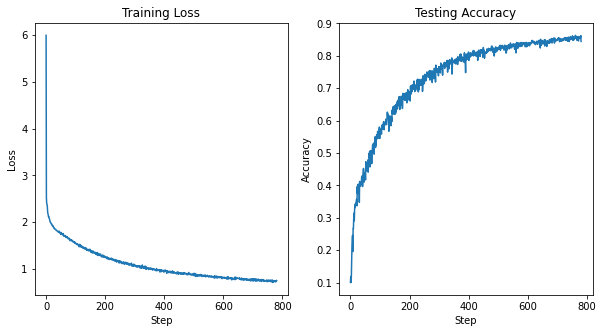

In [ ]:
plot_results(traininglosses, testaccuracy)